<a href="https://colab.research.google.com/github/FusionForce-cloud/assignment-week-5/blob/main/Untitled39.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb

# Load data
train = pd.read_csv("/content/train.csv")  # Colab path
test = pd.read_csv("/content/test (1).csv")    # Colab path
submission = pd.read_csv("/content/sample_submission.csv")  # Colab path

# Save target and drop ID columns
train_ID = train['Id']
test_ID = test['Id']
y = np.log1p(train['SalePrice'])

train.drop(['Id', 'SalePrice'], axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)

# Combine train and test for consistent preprocessing
all_data = pd.concat([train, test], axis=0).reset_index(drop=True)

# Handle missing values
for col in all_data.columns:
    if all_data[col].dtype == "object":
        all_data[col] = all_data[col].fillna("None")
    else:
        all_data[col] = all_data[col].fillna(all_data[col].median())

# Label Encoding for categorical features
for col in all_data.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    all_data[col] = le.fit_transform(all_data[col].astype(str))

# Separate train and test again
n_train = train.shape[0]
X_train = all_data[:n_train]
X_test = all_data[n_train:]

# LightGBM parameters
params = {
    "objective": "regression",
    "metric": "rmse",
    "boosting_type": "gbdt",
    "learning_rate": 0.01,
    "num_leaves": 31,
    "feature_fraction": 0.7,
    "bagging_fraction": 0.7,
    "bagging_freq": 5,
    "verbose": 100,  # Changed from -1 to 100 for verbosity
    "random_state": 42,
    "early_stopping_round": 100
}

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
predictions = np.zeros(X_test.shape[0])

for train_index, val_index in kf.split(X_train, y):
    X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_tr, y_val = y.iloc[train_index], y.iloc[val_index]

    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=10000,
        valid_sets=[lgb_train, lgb_val]
    )

    predictions += model.predict(X_test, num_iteration=model.best_iteration) / kf.n_splits

# Convert back from log1p
submission['SalePrice'] = np.expm1(predictions)
submission['Id'] = test_ID
submission.to_csv("submission.csv", index=False)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Debug] Re-bagging, using 814 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Re-bagging, using 819 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 15
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Re-bagging

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from scipy.stats import skew

# Load data
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test (1).csv")
submission = pd.read_csv("/content/sample_submission.csv")

# Save target and drop ID columns
train_ID = train['Id']
test_ID = test['Id']
y_train = np.log1p(train['SalePrice'])  # Log-transform target

train.drop(['Id', 'SalePrice'], axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)

# Combine train and test for consistent preprocessing
all_data = pd.concat([train, test], axis=0).reset_index(drop=True)

# Feature Engineering
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data['TotalBathrooms'] = all_data['FullBath'] + 0.5 * all_data['HalfBath'] + all_data['BsmtFullBath'] + 0.5 * all_data['BsmtHalfBath']

# Handle missing values
for col in all_data.columns:
    if all_data[col].dtype == "object":
        all_data[col] = all_data[col].fillna("None")
    else:
        all_data[col] = all_data[col].fillna(all_data[col].median())

# Log-transform skewed numerical features
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewed_feats = skewed_feats[abs(skewed_feats) > 0.75]
all_data[skewed_feats.index] = np.log1p(all_data[skewed_feats.index])

# Categorical Encoding
for col in all_data.select_dtypes(include=["object"]).columns:
    if len(all_data[col].unique()) <= 10:  # One-Hot for low cardinality
        all_data = pd.concat([all_data, pd.get_dummies(all_data[col], prefix=col)], axis=1)
        all_data.drop(col, axis=1, inplace=True)
    else:  # Label Encoding for high cardinality (e.g., Neighborhood)
        le = LabelEncoder()
        all_data[col] = le.fit_transform(all_data[col].astype(str))

# Separate train and test
X_train = all_data[:len(train)]
X_test = all_data[len(train):]

# LightGBM parameters (optimized)
params = {
    "objective": "regression",
    "metric": "rmse",
    "boosting_type": "gbdt",
    "learning_rate": 0.01,
    "num_leaves": 31,
    "max_depth": -1,
    "min_child_samples": 20,
    "reg_alpha": 0.1,
    "reg_lambda": 0.1,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "verbose": -1,
    "random_state": 42,
}

# Cross-validation (5-fold)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
predictions = np.zeros(X_test.shape[0])

for train_idx, val_idx in kf.split(X_train, y_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=10000,
        valid_sets=[lgb_train, lgb_val],
        callbacks=[lgb.early_stopping(100, verbose=False)],
    )

    predictions += model.predict(X_test) / kf.n_splits

# Convert back from log1p
submission['SalePrice'] = np.expm1(predictions)
submission.to_csv("submission.csv", index=False)


Training fold 1...
Training until validation scores don't improve for 100 rounds
[200]	train's rmse: 0.126126	valid's rmse: 0.169055
[400]	train's rmse: 0.0876015	valid's rmse: 0.139494
[600]	train's rmse: 0.0730706	valid's rmse: 0.135289
Early stopping, best iteration is:
[628]	train's rmse: 0.0715816	valid's rmse: 0.135028

Training fold 2...
Training until validation scores don't improve for 100 rounds
[200]	train's rmse: 0.128813	valid's rmse: 0.138802
[400]	train's rmse: 0.0899264	valid's rmse: 0.114009
[600]	train's rmse: 0.0743352	valid's rmse: 0.110817
[800]	train's rmse: 0.063851	valid's rmse: 0.110281
Early stopping, best iteration is:
[767]	train's rmse: 0.0653715	valid's rmse: 0.110063

Training fold 3...
Training until validation scores don't improve for 100 rounds
[200]	train's rmse: 0.121597	valid's rmse: 0.162328
[400]	train's rmse: 0.0817874	valid's rmse: 0.15676
Early stopping, best iteration is:
[364]	train's rmse: 0.0858576	valid's rmse: 0.156579

Training fold 4..

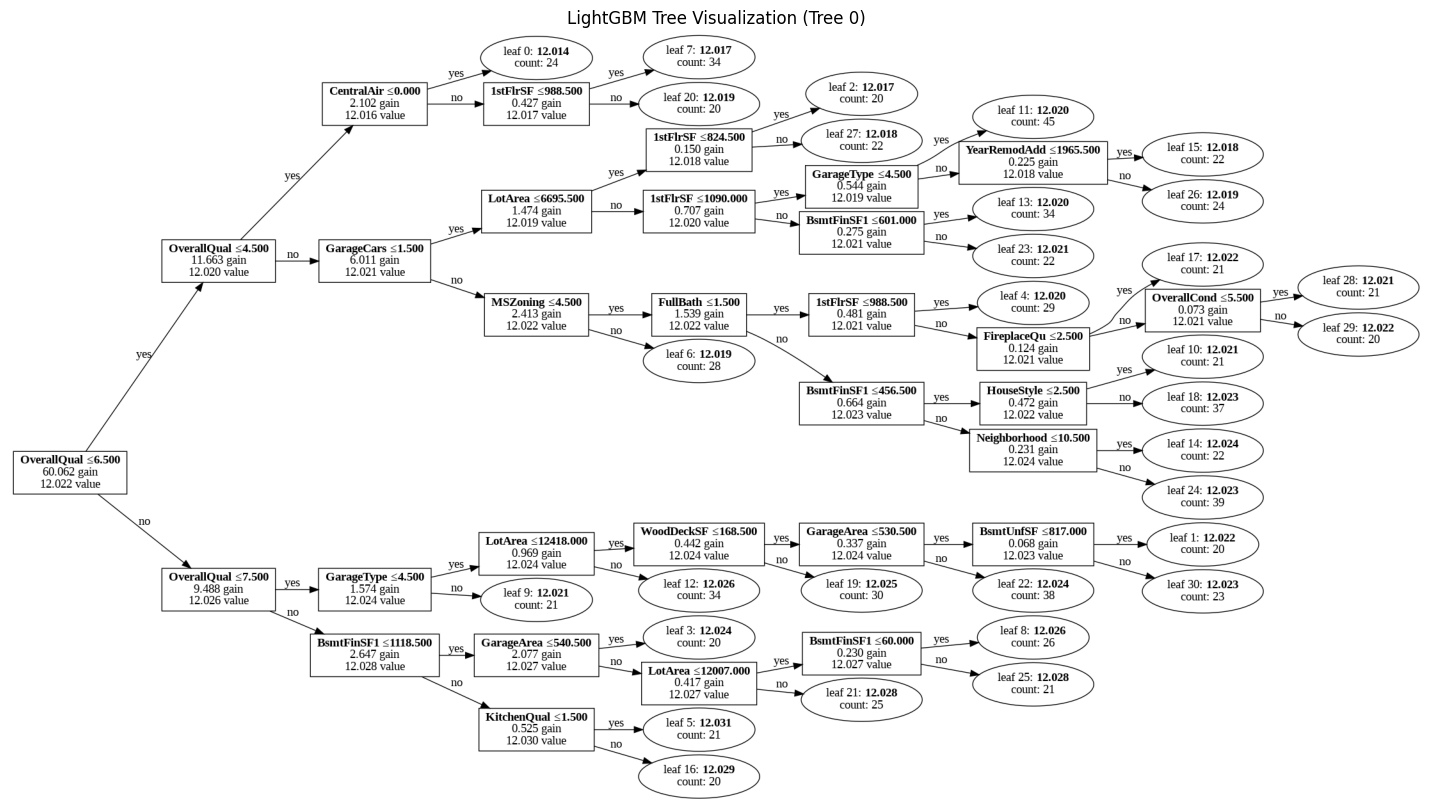

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import matplotlib.pyplot as plt
import lightgbm.plotting as lgb_plot

# Load data
train = pd.read_csv("/content/train.csv")  # Colab path
test = pd.read_csv("/content/test (1).csv")  # Colab path
submission = pd.read_csv("/content/sample_submission.csv")  # Colab path

# Save target and drop ID columns
train_ID = train['Id']
test_ID = test['Id']
y = np.log1p(train['SalePrice'])

train.drop(['Id', 'SalePrice'], axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)

# Combine train and test for consistent preprocessing
all_data = pd.concat([train, test], axis=0).reset_index(drop=True)

# Handle missing values
for col in all_data.columns:
    if all_data[col].dtype == "object":
        all_data[col] = all_data[col].fillna("None")
    else:
        all_data[col] = all_data[col].fillna(all_data[col].median())

# Label Encoding for categorical features
for col in all_data.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    all_data[col] = le.fit_transform(all_data[col].astype(str))

# Separate train and test again
n_train = train.shape[0]
X_train = all_data[:n_train]
X_test = all_data[n_train:]

# LightGBM parameters
params = {
    "objective": "regression",
    "metric": "rmse",
    "boosting_type": "gbdt",
    "learning_rate": 0.01,
    "num_leaves": 31,
    "feature_fraction": 0.7,
    "bagging_fraction": 0.7,
    "bagging_freq": 5,
    "verbose": -1,
    "random_state": 42
}

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
predictions = np.zeros(X_test.shape[0])
model_to_plot = None

for fold, (train_index, val_index) in enumerate(kf.split(X_train, y)):
    print(f"\nTraining fold {fold + 1}...")
    X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_tr, y_val = y.iloc[train_index], y.iloc[val_index]

    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=10000,
        valid_sets=[lgb_train, lgb_val],
        valid_names=['train', 'valid'],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=200)
        ]
    )

    predictions += model.predict(X_test, num_iteration=model.best_iteration) / kf.n_splits
    model_to_plot = model  # Save the model from last fold

# Convert back from log1p
submission['SalePrice'] = np.expm1(predictions)
submission['Id'] = test_ID
submission.to_csv("submission.csv", index=False)

# --- Visualize first tree from last trained model ---
print("\nVisualizing the first tree from the last fold...")
ax = lgb_plot.plot_tree(model_to_plot, tree_index=0, figsize=(20, 10), show_info=['split_gain', 'internal_value', 'leaf_count'])
plt.title("LightGBM Tree Visualization (Tree 0)")
plt.show()
